## PyTorch: Simple Regression

Predicting unknown parameters from known parameters of a simple linear regression using the Y = mx + b formula


In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check torch version
torch.__version__

'2.0.1+cu118'

In [12]:
# Setup device agnoist code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device", device)

Using device cpu


## 1. Data preparing and loading

Use the linear regression formula to make a straight line with *known* **parameters**

Y = mX + b; X - indepedent variable, y - dependent variable, b - slope, b - intercept (bias)

-------------------------
Neural Network Work Flow
1. Get data ready
  * torchvision.transforms
  * torch.utils.data.Dataset
  * torch.utils.data.Dataloader

2. Build model
  * torch.nn
  * torch.nn.Module
  * torch.vision.models
  * torch.optim

3. Evaluate the model
  * torchmetrics

In [13]:
# Create known parameters
weight  = 0.7 # m - slope
bias = 0.3 # b - intercept

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [14]:
len(X), len(y)

(50, 50)

### 1.1 Train/test split

* Training - 20% of data
* Validation - 10% of data (optional)
* Testing - 70% of data

In [15]:
# Split data into 80% training and 20% testing
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [16]:
# Plot the data
def plot_predictions(train_data = X_train,
                     train_label = y_train,
                     test_data = X_test,
                     test_label = y_test,
                     predictions = None):

  """
    Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10,7))

  # Plot raining data in blue
  plt.scatter(train_data, train_label, c= "b", s=4, label = "Training data")

  # Plot testing data in red
  plt.scatter(test_data, test_label, c= "r", s=4, label = "Testing data")

  # Predictions, if any
  if predictions is not None:
      plt.scatter(test_data, predictions, c= "g", s=4, label = "Predictions")

  # Show legend
  plt.legend(prop = {"size": 14})


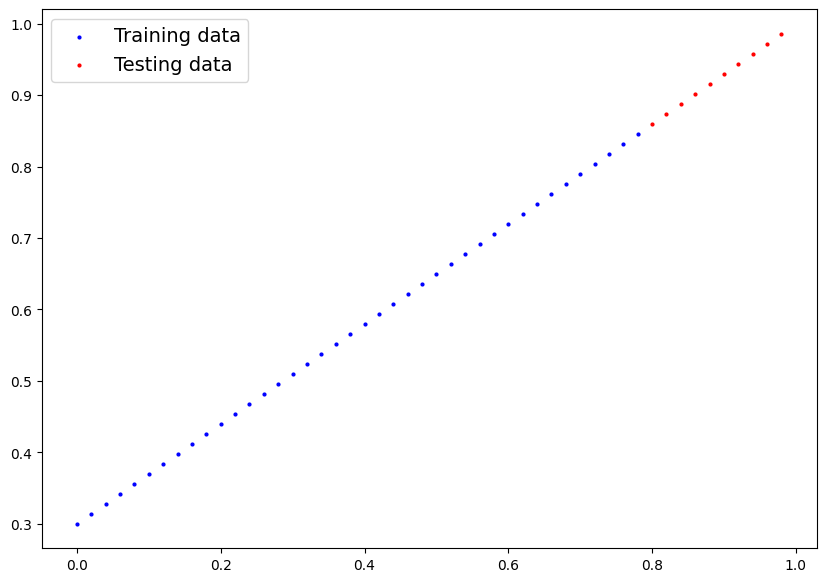

In [8]:
plot_predictions()

## 2. Building a model

In [17]:
# Create Linear Regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # # <- start with random weights (this will get adjusted as the model learns)
                                             dtype = torch.float),
                                             requires_grad = True) # update with gradient descent

    self.bias = nn.Parameter(torch.randn(1,
                                          dtype = torch.float),
                              requires_grad = True)

    # Define the forward pass
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input data
    return self.weights * x + bias # linear regression formula


In [18]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    # use nn.Linear() for creating the model parameters/ also called linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV1()
model_1, model_1.state_dict()


(LinearRegressionModelV1(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### 2.1 Checking the model

In [19]:
# Manual seed
torch.manual_seed(42)

# check the model current device
next(model_1.parameters()).device

# Set the model to use the target device
model_1.to(device)
list(model_1.parameters())

# Create an instance of the model
#model_0 = LinearRegressionModel()

# check out the parameters
#list(model_0.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

In [20]:
# List named parameters
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

## 3. Train model

Measure how wrong your model's performance is through a loss function and optimizer

* Training loop
* Testing loop

In [21]:
# Setup a loss function
loss_fn = nn.L1Loss() # MAE

# Optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

### 3.1 Building a training loop and testing loop

1. Loop through the data
2. Forward pass - function makes predictions
3. Calculate the loss
4. Optimizer zero gradient
5. Loss through back propagation - create gradients for each hyperparameter of the model with respect to the loss
6. Optimizer step - use optimizer to adjust mdoel's parameters to improve the loss (**gradient descent**)

In [22]:
# Setup training loop
torch.manual_seed(42)

# Setup epochs
epochs = 200

# Track model
epoch_count = []
loss_values = []
test_loss_values = []

# Put data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### Training
# 1. Loop through the data
for epoch in range(epochs):

  # Set the model to training model
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train) # (prediction, truth)
  print(f"Loss: ", loss)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  ### Print out model state_dict()
  # print(model_0.state_dict())

  ### Testing loop
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward apss
    test_pred = model_1(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what is going on in the model
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

  epoch_count.append(epoch)
  loss_values.append(loss)
  test_loss_values.append(test_loss)

  ### Print out model state_dict()
  print(model_1.state_dict())

Loss:  tensor(0.5552, grad_fn=<MeanBackward0>)
Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
OrderedDict([('linear_layer.weight', tensor([[0.7606]])), ('linear_layer.bias', tensor([0.8200]))])
Loss:  tensor(0.5437, grad_fn=<MeanBackward0>)
OrderedDict([('linear_layer.weight', tensor([[0.7567]])), ('linear_layer.bias', tensor([0.8100]))])
Loss:  tensor(0.5321, grad_fn=<MeanBackward0>)
OrderedDict([('linear_layer.weight', tensor([[0.7528]])), ('linear_layer.bias', tensor([0.8000]))])
Loss:  tensor(0.5206, grad_fn=<MeanBackward0>)
OrderedDict([('linear_layer.weight', tensor([[0.7489]])), ('linear_layer.bias', tensor([0.7900]))])
Loss:  tensor(0.5091, grad_fn=<MeanBackward0>)
OrderedDict([('linear_layer.weight', tensor([[0.7450]])), ('linear_layer.bias', tensor([0.7800]))])
Loss:  tensor(0.4976, grad_fn=<MeanBackward0>)
OrderedDict([('linear_layer.weight', tensor([[0.7411]])), ('linear_layer.bias', tensor([0.7700]))])
Loss:  tensor(0.4861, grad_fn=<MeanBackward0>)
Ord

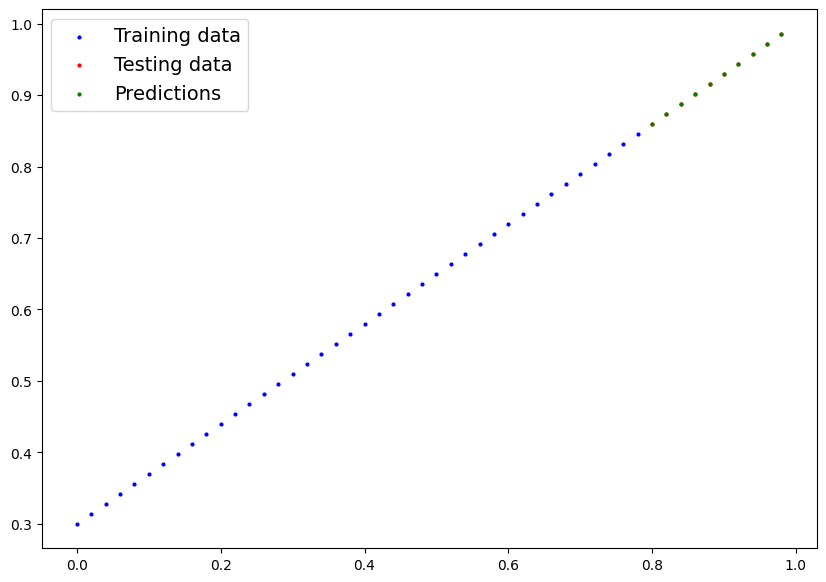

In [23]:
# Evaluation model
model_1.state_dict()

# Turn the model into evalution mode:
model_1.eval()
with torch.inference_mode():
  y_pred_new = model_1(X_test.cpu())

plot_predictions(predictions = y_pred_new.cpu())

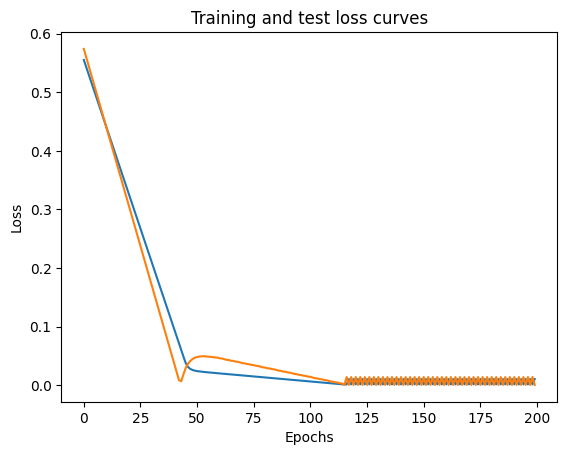

In [24]:
import numpy as np

# Plot loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "train loss")
plt.plot(epoch_count, test_loss_values, label = "test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

## 4. Saving and loading a PyTorch Model

In [26]:
# Save model in PyTorch model
from pathlib import Path

# 1. Create models ddirectory
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save pathg
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# 3. Save the state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),
           f= MODEL_SAVE_PATH)


Saving model to: Models/01_pytorch_workflow_model_0.pth


In [28]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_1 = LinearRegressionModelV1()

# load the save state_dict of model_0 (thois will update the new instance with updated paremters)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_1.state_dict() # note the paremters are random

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [29]:
# Make some predictions iwth our loaded model
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_1(X_test)

loaded_model_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

In [30]:
# Make some models preds
model_1.eval()
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

In [31]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])